In [108]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import os
from os import listdir
from os.path import isfile, join

import torchvision.models.segmentation
import torch
from torchsummary import summary
import torchvision.transforms as tf
import torch.nn as nn
import torch.nn.functional as F

In [109]:
path = 'TestFrames/'
dataFiles = []

for file in [f for f in listdir(path) if isfile(join(path, f))]:
    angle = file.split('_')[2][:-4]
    dataFiles.append(path + file)

In [110]:
dataFiles

['TestFrames/8ofMar0001_angleNorm_0.48880475759506226.jpg',
 'TestFrames/8ofMar17878_angleNorm_0.5151078701019287.jpg',
 'TestFrames/8ofMar0407_angleNorm_0.5309815406799316.jpg',
 'TestFrames/8ofMar49620_angleNorm_0.4392962157726288.jpg',
 'TestFrames/8ofMar0088_angleNorm_0.465093731880188.jpg',
 'TestFrames/8ofMar0012_angleNorm_0.4745853841304779.jpg']

In [111]:
imagePath = dataFiles[0]

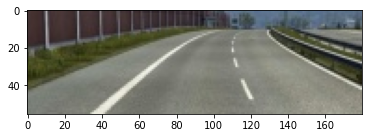

In [112]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

img = get_image(imagePath)
plt.imshow(img)

In [113]:
width = 180
height = 56

def LoadImg(path):
    image = Image.open(path)
    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))
    return image

In [114]:
imageTensor = LoadImg(imagePath)

In [115]:
class netNvidia(nn.Module):
    def __init__(self):
        super(netNvidia, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3,24,5, stride=2),
            nn.ReLU(),
            #need to output this layer...
            nn.Conv2d(24,36,5, stride=2),
            nn.ReLU(),
            nn.Conv2d(36,48, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(48,64,3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3, padding=1),
            #nn.Flatten(),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64*4*19, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1),
        )

    def forward(self, input):
        input = input.view(input.size(0), 3, height, width)
        output = self.conv_layers(input)
        #print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

In [116]:
model = netNvidia().cuda()
torch.device('cuda')
summary(model, (3, height, width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 26, 88]           1,824
              ReLU-2           [-1, 24, 26, 88]               0
            Conv2d-3           [-1, 36, 11, 42]          21,636
              ReLU-4           [-1, 36, 11, 42]               0
            Conv2d-5            [-1, 48, 4, 19]          43,248
              ReLU-6            [-1, 48, 4, 19]               0
            Conv2d-7            [-1, 64, 4, 19]          27,712
              ReLU-8            [-1, 64, 4, 19]               0
            Conv2d-9            [-1, 64, 4, 19]          36,928
          Dropout-10            [-1, 64, 4, 19]               0
           Linear-11                  [-1, 100]         486,500
             ReLU-12                  [-1, 100]               0
           Linear-13                   [-1, 50]           5,050
             ReLU-14                   

In [117]:
torch.cuda.is_available()

True

In [118]:
model = netNvidia()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model = model.to(device)
model.eval()

netNvidia(
  (conv_layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=4864, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [120]:
imageTensor = imageTensor.to(device).unsqueeze(0)

with torch.no_grad():
    prediction = model(imageTensor)  # Run net

predAngles  = prediction.data.cpu().numpy()

In [121]:
model.cpu()
featureMap = model.conv_layers[2].weight.detach().numpy()

newMap = np.asarray([ [0]*featureMap.shape[1] for i in range(featureMap.shape[0])])

for i in range(0,featureMap.shape[0]):
    for j in range(0,featureMap.shape[1]):
        newMap[i][j] = np.average(featureMap[i][j])

featureMap = newMap


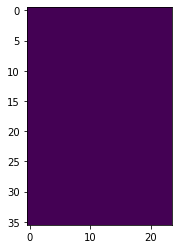

In [122]:
plt.imshow(featureMap)